## Setting up paths

In [1]:
#setting up the file paths

import sys
sys.path.append("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI")
sys.path.append("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Stochastic LSR TRR/Code Files")

## Importing Libraries

In [2]:
#importing the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
from sgd_optimization import SGD
import pandas as pd
import re
import scipy
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dill

from KFoldCV import KFoldCV
from train_test import train_test
from sgd_optimization import SGD
from DataGenerationB import *



## Importing HCP Data

In [3]:
#Load data from npy file
with open("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Each sample is a row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

In [4]:
#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape labels into column vector
X_train_vec, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test_vec, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Coversion: FC Vectors --> FC Matrices

In [5]:
#conversion of the HCP data from Vector --> Matrix
 
def vectomat(dataset,output_dim):
    '''
    This functio is made to convert the  FC value vector of the samples in the dataset 
    to the functional connectivity matrix

    dataset: the dataset with n_samples*n_features
    '''
    #number of samples
    n_samples = dataset.shape[0]
    #empty array to hold the reconstructed FC matrices
    out_dataset = np.zeros((n_samples,output_dim,output_dim))
    #indices for the upper triangle without the diagonal 
    upper_traingle_indices = np.triu_indices(400,k=1)

    #iterating over the samples and making the 

    for i in range(n_samples):
        sample = np.zeros((output_dim,output_dim)) 
        np.fill_diagonal(sample,1)
        sample[upper_traingle_indices] = dataset[i]
        sample = sample + sample.T - np.diag(sample.diagonal())
        out_dataset[i] = sample
    
    # Assuming `all_matrices` is the 3D array created previously
    # Select a random sample
    random_index = np.random.randint(0, n_samples)
    random_sample = out_dataset[random_index]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(random_sample, cmap='viridis', cbar=True)
    plt.title(f'Heatmap of Random Sample {random_index}')
    plt.show()

    return out_dataset

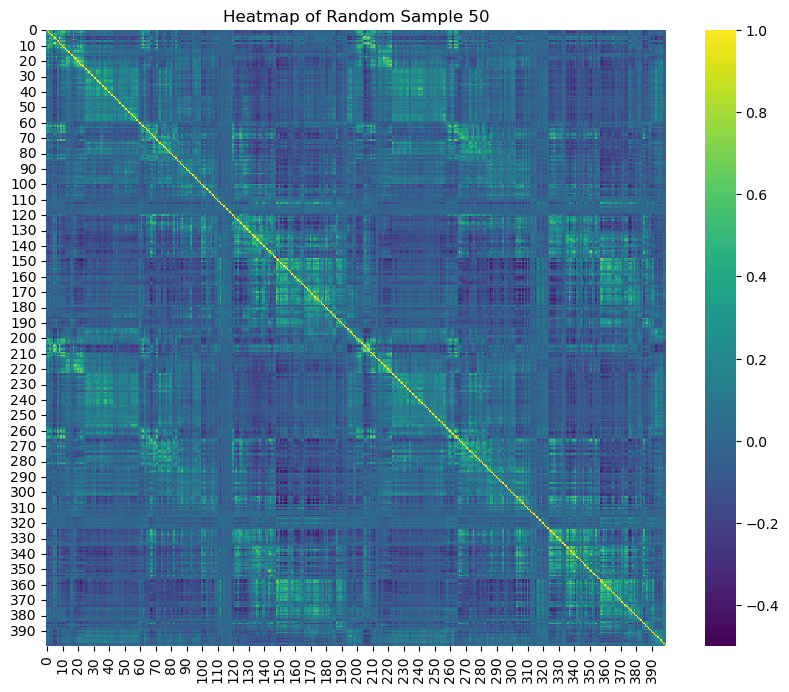

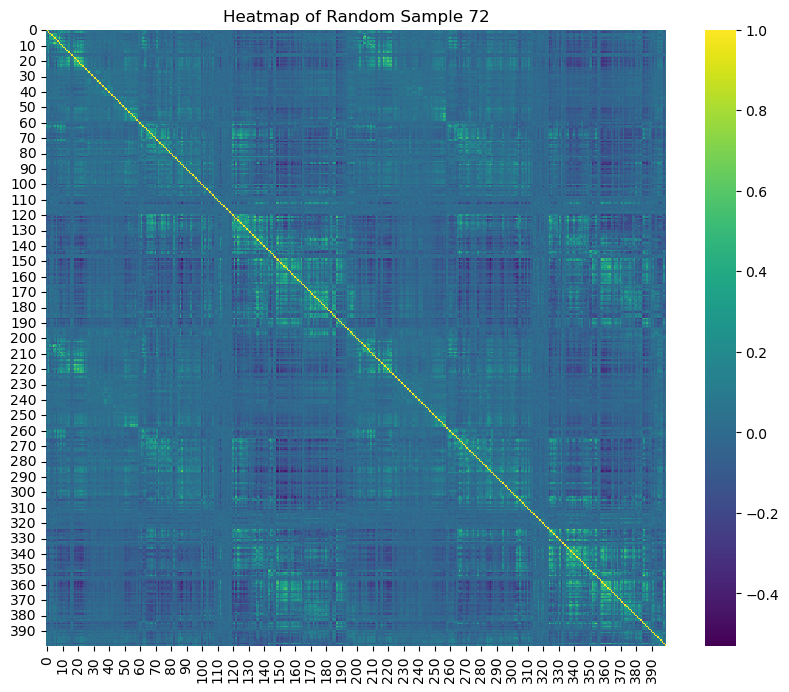

(677, 400, 400)
(677,)
(76, 400, 400)
(76,)


In [6]:
#Training data
X_train = vectomat(X_train_vec,400)
X_test  = vectomat(X_test_vec,400)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


## Pre-processing 

In [7]:

#Preprocessing

#number of samples in train and test 
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)

X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)

# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, X_train.shape[1],X_train.shape[2])
X_test  = X_test_scaled.reshape(n_test, X_test.shape[1],X_train.shape[2])

#average response value
Y_train_mean = np.mean(Y_train)
# Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)




Sample mean for each feature (across samples): [1.         0.33170613 0.35946642 ... 0.19885258 0.29165831 1.        ]
Sample variance for each feature (across samples): None
Response Average: 1.127096656182391


## Hyper-parameters

In [8]:
#LSR Hypers

#Tensor Dimensions
tensor_dimensions = np.array([400, 400])
#Tensor Tucker Ranks
tensor_mode_ranks = np.array([3, 3])
#Sepration Rank
separation_rank = 2

#Cross - Validation 

#For now, define finite alpha set that we are searching over
alphas = [5.1]   #0,0.1,0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3, 5, 4,10,15,20,50,100
#Define Number of Folds we want
k_folds = 5

# Optimization Hypers

learning_rate = 0.000002
epochs = 100
batch_size = 32




In [9]:
#Training  
hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size}
lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information,gradient_information = KFoldCV(X_train, Y_train, alphas, k_folds, hypers,B_tensored = None ,intercept= False) 

#Testing 
hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size}
normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values = train_test(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,B_tensored = None, intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Record on Training _ After K-Fold CV")
print("Validation Normalized Estimation Error: ", validation_normalized_estimation_error)
print("Validation NMSE Losses: ", validation_nmse_losses)
print("Validation Correlations: ", validation_correlations)
print("Validation R2 Scores: ", validation_R2_scores)

print("Error Report on Testing _ With best Lambda")
print("Alpha chosen for model: ", lambda1)
print("Test Normalized Estimation Error: ", normalized_estimation_error)
print("Test NMSE Loss: ", test_nmse_loss)
print("Test R2 Loss: ", test_R2_loss)
print("Test Correlation: ", test_correlation)

with open(pkl_file, "wb") as file:
  dill.dump((lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information, normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_information,gradient_values), file)

intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
intercept is not initialized
Fold = 0, Alpha = 5.1, NMSE: 0.9979480779448979, Correlation: 0.23360244354985663, R^2 Score: 0.0019887530889374228
